# Selecting Assets

In [1]:
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
import seaborn as sn
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime as dt
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
import websocket
import json
import time
from datetime import datetime
import sys

#Alpaca imports
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce

import os
os.environ['APCA_API_BASE_URL'] = 'https://paper-api.alpaca.markets'



#Storage
order_history = pd.DataFrame()
spread_visualisations = {}
zscore_visualisations = {}

plt.style.use('fivethirtyeight')

#Setting dataset for the model
END_DATE = dt.date.today()
START_DATE = END_DATE-pd.DateOffset(days=365)

SYMBOLS_LIST = ['XOM', 'CVX', 'BP', 'COP', 'PXD', 'EOG', 'APA', 'OXY', 'MPC', 'SLB', 'HAL', 'KMI', 'PBR', 'SU', 'ENB', 'EPD', 'EQT', 'BHP', 'VALE', 'RIO', 'FCX', 'NEM', 'GOLD', 'WPM', 'AGI', 'TECK', 'SBSW', 'CF', 'ADM', 'MOS', 'FMC', 'LIN', 'NUE', 'RGLD', 'WY', 'PAA', 'ET', 'MPLX', 'WMB', 'X', 'AA', 'CMP', 'IP', 'PKG', 'PPG']




prices_df = yf.download(tickers=SYMBOLS_LIST, start=START_DATE, end=END_DATE)['Adj Close']
prices_df = prices_df.dropna(axis=0)

#Finding the highest correlation pairs
corr_matrix = prices_df.corr().abs()
cmu = corr_matrix.unstack()
cmu = cmu[cmu != 1]
cmu = cmu[~cmu.duplicated()]
cmu = cmu.sort_values(kind="quicksort", ascending=False)
cmu = cmu.reset_index()
cmu = cmu.rename(columns={"level_0" : 'Stock_1', "level_1": 'Stock_2', 0: 'Correlation'})


highest_corr_pairs = cmu[cmu['Correlation'] >= 0.80]
highest_corr_pairs['lookup'] = highest_corr_pairs['Stock_1'] + ' - '+ highest_corr_pairs['Stock_2']
highest_corr_pairs
prices_df

[*********************100%***********************]  45 of 45 completed


C:\Users\aidan\AppData\Local\Temp\ipykernel_8084\3186964423.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highest_corr_pairs['lookup'] = highest_corr_pairs['Stock_1'] + ' - '+ highest_corr_pairs['Stock_2']


,AA,ADM,AGI,APA,BHP,BP,CF,CMP,COP,CVX,...,SBSW,SLB,SU,TECK,VALE,WMB,WPM,WY,X,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2022-08-18,53.297924,85.802910,7.661295,35.613213,53.487167,30.574373,100.392563,43.123440,99.724709,153.425247,...,8.946502,36.461697,31.489714,33.918526,12.378070,33.359432,32.084454,34.905350,23.460905,91.363106
2022-08-19,50.496414,85.420998,7.473227,35.271717,53.131397,30.181658,101.500740,41.793987,99.971924,152.142044,...,8.572170,36.451878,31.098831,33.340317,12.170193,33.065975,31.473696,34.429798,22.935585,91.072693
2022-08-22,49.763866,84.745308,7.473227,35.896168,53.655693,30.373224,103.599388,40.651642,100.067024,151.379837,...,8.628321,36.255478,31.318106,33.418716,12.066256,32.838779,31.641161,33.611847,22.410267,91.004929
2022-08-23,52.555473,86.223999,7.720685,37.847580,55.041321,31.177813,106.943527,40.858448,103.119232,156.290771,...,8.740620,38.651566,32.719555,35.349361,13.001697,33.245831,32.035202,33.773537,23.054525,94.867393
2022-08-24,53.881981,86.801750,7.839465,39.330650,54.442131,30.928778,110.326889,41.537945,105.087486,157.448547,...,8.843560,39.191662,32.996033,34.878948,12.576496,33.681290,32.330723,34.249088,23.837545,95.428856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-11,31.959999,84.370636,11.670000,44.880001,58.959999,37.099998,79.489998,33.880001,117.299477,162.587448,...,6.790000,59.650002,31.719999,40.349998,12.914000,35.380001,45.250000,33.020000,22.719999,110.920738
2023-08-14,31.730000,84.490005,11.580000,44.660000,57.840000,36.680000,78.059998,33.000000,117.180000,162.468597,...,6.380000,59.520000,31.530001,39.840000,12.470000,35.029999,44.270000,33.130001,31.080000,111.010002
2023-08-15,30.340000,82.430000,11.410000,43.860001,56.660000,36.070000,77.150002,30.650000,115.510002,157.724197,...,6.290000,58.330002,31.040001,37.939999,12.270000,34.759998,42.439999,32.730000,30.230000,108.160004


In [2]:
def connect_to_alpaca():
    global trading_client
    
    api_key = ''
    api_secret = ''
    
    trading_client = TradingClient(api_key, api_secret, paper=True)
    account = trading_client.get_account()
    print('Connected to ALPACA')
    print('${} is available as buying power.'.format(account.buying_power))

In [3]:
def find_cointegrated_pairs(df, p_value_thresh):
        n = len(df.columns)
        pairs = {}
        for i in range(n):
            for j in range(i+1, n):
                S1 = df.iloc[:,i]
                S2 = df.iloc[:,j]
                result = coint(S1, S2, trend="c", autolag="BIC")
                pvalue = round(result[1], 5)
                if pvalue <= p_value_thresh:
                    pairs[f"{df.columns[i]} - {df.columns[j]}"] = pvalue
        return pairs

#Filtering for pairs with cointegration below threshold(0.05)
pairs = find_cointegrated_pairs(df=prices_df, p_value_thresh=0.05)
pairs_df = pd.DataFrame.from_dict(pairs, orient='index')
pairs_df = pairs_df.rename(columns={0: 'Cointegration'})
pairs_df
# #Mergin with df of highest correlation pairs
highest_corr_pairs = highest_corr_pairs.merge(pairs_df, left_on='lookup', right_on=pairs_df.index)
highest_corr_pairs

,Stock_1,Stock_2,Correlation,lookup,Cointegration
0,BHP,RIO,0.985955,BHP - RIO,0.01316
1,ET,MPLX,0.954294,ET - MPLX,0.00201
2,COP,EOG,0.939905,COP - EOG,0.03741
3,AGI,CF,0.880557,AGI - CF,0.03684
4,AGI,TECK,0.877112,AGI - TECK,0.03454
5,TECK,WPM,0.862301,TECK - WPM,0.02491
6,ADM,APA,0.861557,ADM - APA,0.02560
7,CF,OXY,0.817152,CF - OXY,0.01874


In [4]:
def downloaded_stockdata(stock_1, stock_2):
    # Downloading the required data
    selected_df = yf.download(tickers=[stock_1, stock_2],
                              start=START_DATE,
                              end=dt.date.today() + dt.timedelta(days=1))
# #     #Adding the real latest price
#     selected_df.loc[selected_df.index[-1], ('Adj Close', stock_1)] =  get_last_price((bybit_string_conversion(stock_1)))
#     selected_df.loc[selected_df.index[-1], ('Adj Close', stock_2)] =  get_last_price((bybit_string_conversion(stock_2)))

    selected_df = selected_df.stack()

    
#     #Finding the required metrics
    selected_df['return'] = (selected_df['Adj Close']-selected_df['Open'])/selected_df['Open']
    selected_df['forward_return'] = selected_df.groupby(level=1)['return'].transform(lambda x: x.shift(-1))
    selected_df = selected_df[['Adj Close', 'forward_return']].unstack().droplevel(axis=1, level=0)
    

    selected_df.columns = [stock_1, stock_2, f'{stock_1}_forward_return', f'{stock_2}_forward_return']
    selected_df[f'{stock_1}_return'] = np.log(selected_df[stock_1]).diff()
    selected_df[f'{stock_2}_return'] = np.log(selected_df[stock_2]).diff()
    selected_df['hedge_ratio'] = RollingOLS(selected_df[f'{stock_2}_return'],
                                            selected_df[f'{stock_1}_return'],
                                            window=60).fit().params.values
    selected_df['spread'] = (selected_df[stock_1]-selected_df[stock_2]*selected_df['hedge_ratio'])
    
    #Correlation test
    selected_df['roll_corr'] = selected_df[stock_1].rolling(180).corr(selected_df[stock_2])
    
    # ZScore
    def smooth_zscore(spread):
        return (spread.rolling(1).mean()-spread.rolling(50).mean())/spread.rolling(50).std()
    
    selected_df['zscored'] = smooth_zscore(selected_df['spread'])
    
    #Trading Signal
    selected_df['signal'] = selected_df.apply(lambda x: 1 if (x['zscored']<-1)
                                              else (-1 if (x['zscored']>1) else 0), axis=1)
    
    return selected_df

In [5]:
def adf_test(stock_1, stock_2):
    removed_na_df = downloaded_stockdata(stock_1, stock_2).dropna()
    adf_result = adfuller(removed_na_df['spread'])[1]

    if adf_result <= 0.05:
        return ('P-Value: ' + str(round(adf_result, 2)) + ' - Passed')
    else:
        return ('P-Value: ' + str(round(adf_result, 2)) + ' - Failed')

# Running ADF test
adf_list = []
for n in range(len(highest_corr_pairs)):
    result = adf_test(highest_corr_pairs['Stock_1'][n], highest_corr_pairs['Stock_2'][n])
    adf_list.append(result)

highest_corr_pairs['adf_test'] = adf_list
highest_corr_pairs

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


,Stock_1,Stock_2,Correlation,lookup,Cointegration,adf_test
0,BHP,RIO,0.985955,BHP - RIO,0.01316,P-Value: 0.47 - Failed
1,ET,MPLX,0.954294,ET - MPLX,0.00201,P-Value: 0.55 - Failed
2,COP,EOG,0.939905,COP - EOG,0.03741,P-Value: 0.58 - Failed
3,AGI,CF,0.880557,AGI - CF,0.03684,P-Value: 0.34 - Failed
4,AGI,TECK,0.877112,AGI - TECK,0.03454,P-Value: 0.13 - Failed
5,TECK,WPM,0.862301,TECK - WPM,0.02491,P-Value: 0.88 - Failed
6,ADM,APA,0.861557,ADM - APA,0.02560,P-Value: 0.82 - Failed
7,CF,OXY,0.817152,CF - OXY,0.01874,P-Value: 0.74 - Failed


In [6]:
def gather_data(stock_1, stock_2):
    global last_day, last_signal, hr, selected_df
    #Assign selected_df  and last_day variable
    selected_df = downloaded_stockdata(stock_1, stock_2)
    print('Collected historical data')
    
    last_day = selected_df.tail(1) 
    last_signal = last_day.signal.values[0]
    hr = round(last_day.hedge_ratio.values[0], 2)
    
    print('Analysed signals')


In [7]:
def pause_algo():
    for remaining in range(5*60*60, 0, -1):
        sys.stdout.write("\r")
        sys.stdout.write("Paused Algorithm ")
        sys.stdout.write("{:2d} seconds remaining.".format(remaining))
        sys.stdout.flush()
        time.sleep(1)

In [8]:
def enter_long_hedge_position(stock_1, stock_2, leverage):
    
    global trading_client, hr

    #Placing Buy order of 1
    market_order = trading_client.submit_order(
                order_data=MarketOrderRequest(
                    symbol=stock_1,
                    qty=1*leverage,
                    side=OrderSide.BUY,
                    time_in_force=TimeInForce.DAY
                    ))
    print(stock_1 +' LONG order executed')

    #Placing Short Order of Hedge Ratio Dot
    market_order_2 = trading_client.submit_order(
                order_data=MarketOrderRequest(
                    symbol=stock_2,
                    qty=round(hr*leverage),
                    side=OrderSide.SELL,
                    time_in_force=TimeInForce.DAY
                    ))
    print(stock_2+' SHORT order executed')

In [9]:
def enter_short_hedge_position(stock_1, stock_2, leverage):
    global trading_client, hr

    #Placing Buy order of 1 AAVE
    
    market_order = trading_client.submit_order(
            order_data=MarketOrderRequest(
                symbol=stock_1,
                qty=1*leverage,
                side=OrderSide.SELL,
                time_in_force=TimeInForce.DAY
                ))
    print(stock_1 +' SHORT order executed')

    #Placing Short Order of Hedge Ratio Dot
    market_order = trading_client.submit_order(
            order_data=MarketOrderRequest(
                symbol=stock_1,
                qty=hr*leverage,
                side=OrderSide.BUY,
                time_in_force=TimeInForce.DAY
                ))
    
    print(stock_2+' LONG order executed')


In [10]:
def positions():
    assets = pd.DataFrame()
    if in_position():
        for n in range(len(trading_client.get_all_positions())):
            pos = dict(trading_client.get_all_positions()[n])
            pos = pd.DataFrame.from_dict(pos, orient='index').T
            assets = pd.concat([assets, pos])
            
            #Changin columns from str to float type
            columns_to_convert = ['unrealized_pl', 'cost_basis', 'market_value',
                                  'avg_entry_price', 'qty','unrealized_plpc' ]
            for column in columns_to_convert:
                assets[column] = assets[column].astype(float)    
    return assets

def unrealised_profit(stock_1, stock_2):
    filtered_pos = positions()[positions()['symbol'].isin([stock_1, stock_2])]
    
    unrealised_profit = filtered_pos['unrealized_pl'].sum()
    cost_basis = filtered_pos['cost_basis'].sum()
    percent_profit = unrealised_profit/cost_basis
    
    return unrealised_profit, percent_profit


In [11]:
def take_profit(stock):
    
    side = str(positions().query("symbol == @stock")['side'][0])
    qty = str(positions().query("symbol == @stock")['qty'][0])
    
    def extract_position_side(string):
        return string.split('.')[-1]
    
    if side == 'PositionSide.LONG':
            market_order = trading_client.submit_order(
                    order_data=MarketOrderRequest(
                        symbol=stock,
                        qty=qty,
                        side=OrderSide.SELL,
                        time_in_force=TimeInForce.DAY
                        ))
            print('Sold ' + qty + ' shares of ' + stock + ' to exit ' + extract_position_side(side) + ' position')
            
    elif side == 'PositionSide.SHORT':
        market_order = trading_client.submit_order(
                order_data=MarketOrderRequest(
                    symbol=stock,
                    qty=qty,
                    side=OrderSide.BUY,
                    time_in_force=TimeInForce.DAY
                    ))
        print('Longed ' + qty + ' shares of ' + stock + ' to exit ' + extract_position_side(side) + ' position')


In [12]:
def in_position():
    global trading_client
    return bool(trading_client.get_all_positions())

In [13]:
def execute_algo(stock_1, stock_2, leverage):#ENSURE TO ADD CORRECT ASSETS HERE
    #defining global variables
    global trading_client, last_day, last_signal, hr
    
    sys.stdout.write('\n')
    print('Assets chosen: ' + stock_1 + ' and ' + stock_2)
    print('Leverage: ' + str(leverage))
    
    #Connect to exchange
    connect_to_alpaca()
    
    while not in_position():
        #Collect the data 
        gather_data(stock_1, stock_2)
        #Trade execution
        if last_signal == 1:
            enter_long_hedge_position(stock_1, stock_2, leverage)

        elif last_signal == -1:
            enter_short_hedge_position(stock_1, stock_2, leverage)

    count = 0
    while in_position():
        
        unrealised_abs = round(unrealised_profit(stock_1, stock_2)[0], 3)
        percent_profit = round(unrealised_profit(stock_1, stock_2)[1], 3)
        
        sys.stdout.write("\r")
        sys.stdout.write(str(count) + '_Current Profit: ' + str(unrealised_abs) + ' = '+ str(percent_profit) + '%')
        sys.stdout.flush()

        if percent_profit > 0.05:
            sys.stdout.write("\n")
            print('Take Profit Hit')
            take_profit(stock_1)
            take_profit(stock_2)
            pause_algo()

        if percent_profit < -0.025:
            sys.stdout.write("\n")
            print('Stop Loss Hit')
            take_profit(stock_1)
            take_profit(stock_2)
            pause_algo()

        count +=1
    
        if not in_position():
            execute_algo(stock_1, stock_2, leverage)


In [14]:
execute_algo('TECK', 'WPM', 5)



Assets chosen: TECK and WPM
Leverage: 5
Connected to ALPACA
$199487.1 is available as buying power.
0_Current Profit: -21.94 = -0.066%
Stop Loss Hit
Sold 10.0 shares of TECK to exit LONG position


APIError: {"code":40010001,"message":"qty must be \u003e 0"}

In [ ]:
# dates_ran = []

# def check_date():
#     today = datetime.now()
#     dates_ran.append(today.strftime("%m/%d/%Y"))
#     time.sleep(10)
#     if len(dates_ran) < 100:
#         execute_algo()
#         return check_date()
    
# # check_date()

# 4. Visualize The Spread

[*********************100%***********************]  2 of 2 completed


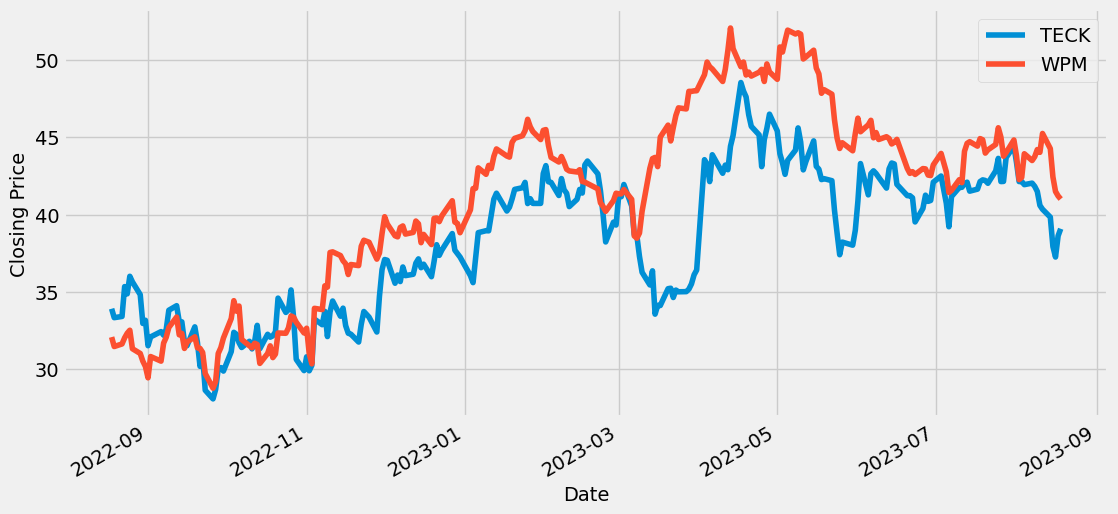

In [15]:
ax = downloaded_stockdata('TECK', 'WPM')[['TECK','WPM']].plot(figsize=(12, 6))#, title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
ax.grid(True);


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


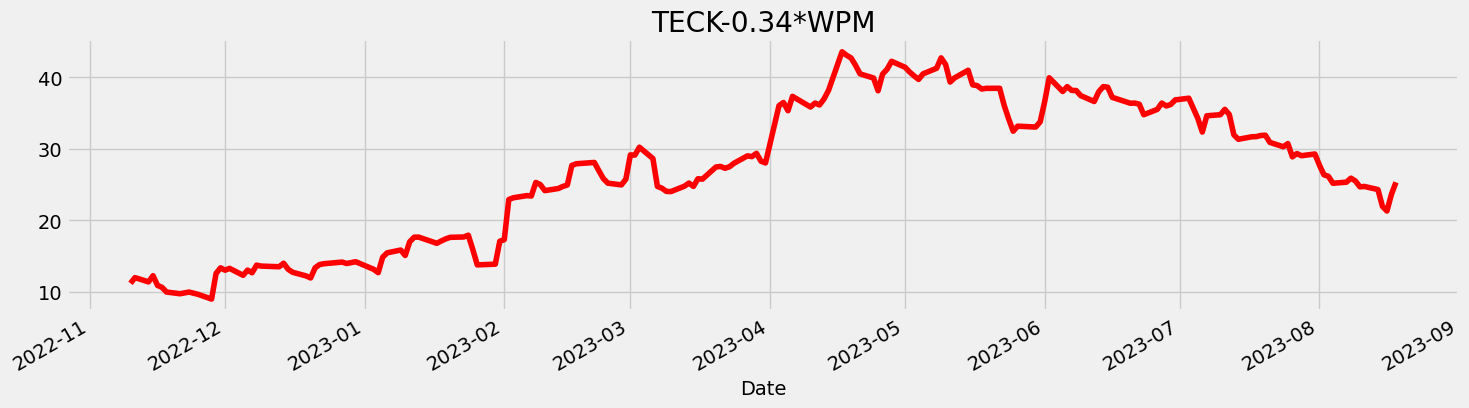

In [16]:
def spread_visualisation(stock_1, stock_2):
    selected_df = downloaded_stockdata(stock_1, stock_2) 
    plt.title(f'{stock_1}-{round(selected_df.hedge_ratio[-1],2)}*{stock_2}')
    downloaded_stockdata(stock_1, stock_2)['spread'].plot(figsize=(16,4), color='red')
    
spread_visualisation('TECK', 'WPM')

[*********************100%***********************]  2 of 2 completed


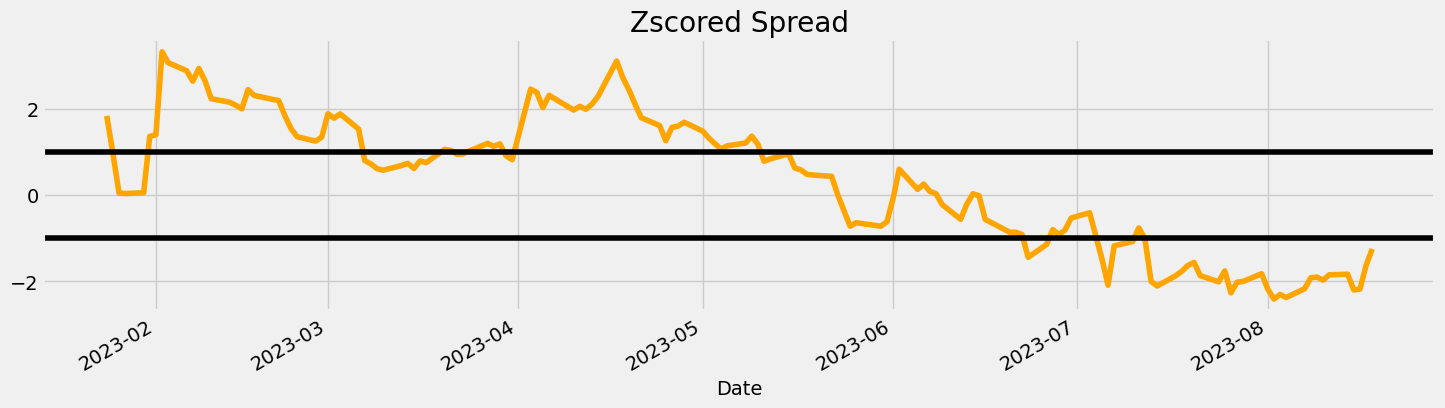

In [17]:
def zscored_spread(stock_1, stock_2):
    downloaded_stockdata(stock_1, stock_2)['zscored'].plot(figsize=(16,4), color='orange')
    plt.title('Zscored Spread')
    plt.axhline(1, color='k')
    plt.axhline(-1, color='k')
    
zscored_spread('TECK', 'WPM')

[*********************100%***********************]  2 of 2 completed


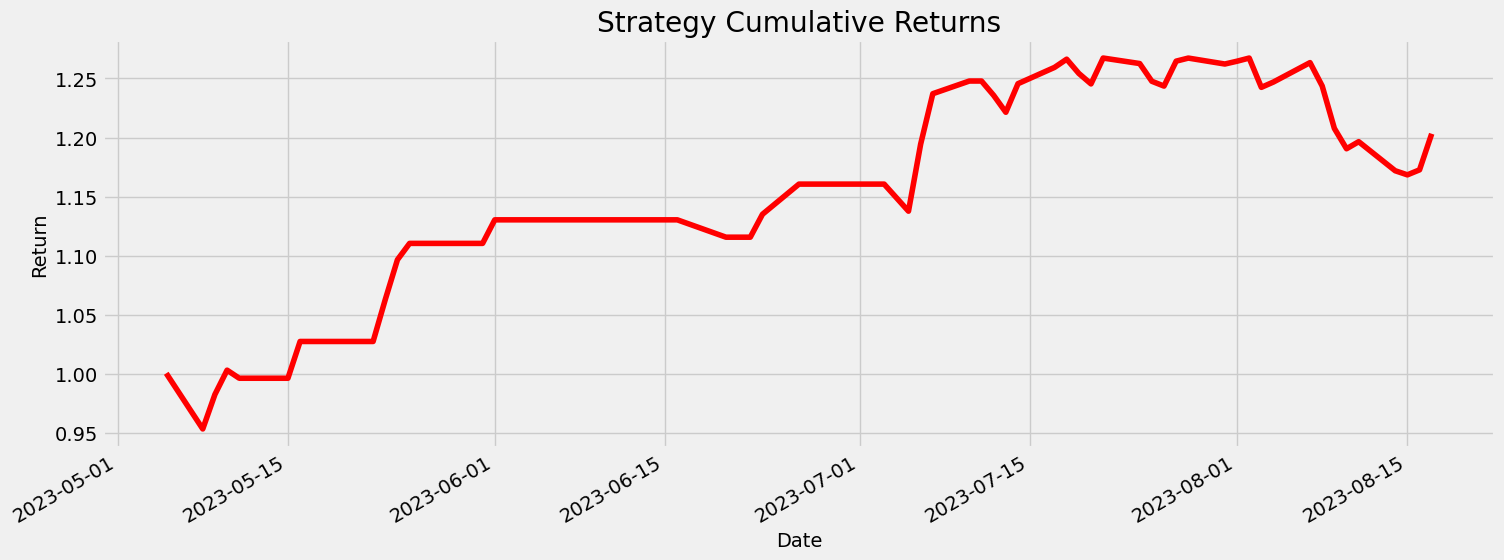

In [19]:
def visualise_returns(stock_1, stock_2, tp, sl):
    return_df = downloaded_stockdata(stock_1, stock_2).dropna()
    return_df['combined_return'] = return_df[f'{stock_1}_return'] + return_df[f'{stock_2}_return']
        #Trading Signal
    return_df['signal'] = return_df.apply(lambda x: 1 if ((x['zscored']<-1) or (x['combined_return']>tp))
                                              else (-1 if ((x['zscored']>1) or (x['combined_return']<sl)) else 0), axis=1)
    return_df['strategy_return'] = return_df[f'{stock_1}_forward_return']*return_df['signal'] +\
                                 return_df[f'{stock_2}_forward_return']*return_df['signal']*-return_df['hedge_ratio']

    portfolios_cumulative_return = np.exp(np.log1p(return_df['strategy_return']).cumsum())
    portfolios_cumulative_return.plot(figsize=(16,6), color='red')
    plt.title('Strategy Cumulative Returns')
    plt.ylabel('Return')
    plt.show()
    
visualise_returns('TECK', 'WPM', 0.05, -0.05)